In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datasets import load_dataset
import evaluate
import pickle
import time
from tqdm.notebook import tqdm
from nltk.corpus import wordnet as wn
import json

tqdm.pandas()

Loading the taxonomy

In [2]:
emb_sh = "_jbEn"
with open(f"../../data/taxonomy/taxonomy_embeddings{emb_sh}.pkl", "rb") as f:
    emb_tax = pickle.load(f)
    emb_tax["name"] = emb_tax["name+definition"].apply(lambda x : x.split(" : ")[0])

In [93]:
from collections import Counter

for nd in emb_tax["name+definition"][:10]:
    w = nd.split(" : ")[0].split(" ")[0]

    pos_l = list()
    for tmp in wn.synsets(w):
            if tmp.name().split('.')[0] == w:
                pos_l.append(tmp.pos())
    cnts = Counter(pos_l).most_common(1)
    if(len(cnts) == 0):
         ty = 'n'
    else :
         ty = cnts[0][0]
    print("w = ", w, ", class=", ty)
    

w =  manage , class= v
w =  supervise , class= n
w =  apply , class= v
w =  control , class= n
w =  identify , class= v
w =  perform , class= v
w =  ensure , class= n
w =  Haskell , class= n
w =  show , class= v
w =  train , class= v


In [3]:
import spacy

nlp = spacy.load("en_core_web_sm")

for nd in emb_tax["name+definition"][:10]:
    text = nd.split(" : ")[0]
    doc = nlp(text) 
    
    # checking if it is a noun or not 
    if(doc[0].tag_ == 'NNP'): 
        print("w = ", text.split(" ")[0], ", class = NN") 
    else: 
        print("w = ", text.split(" ")[0], ", class = V") 

w =  manage , class = V
w =  supervise , class = V
w =  apply , class = V
w =  control , class = NN
w =  identify , class = V
w =  perform , class = V
w =  ensure , class = V
w =  Haskell , class = NN
w =  show , class = V
w =  train , class = V


In [30]:
def format_input(name):
    if(type(name) != 'str' and len(name) == 2):
        defin = ", which consist of : " + name[1]
        name = name[0]
    elif len(name) == 1:
        name = name[0]
        defin = ""
    else :
        defin = ""

    doc = nlp(name) 
    is_noun = doc[0].tag_ == 'NNP'
    return f"i want to learn {'' if is_noun else 'to '}{name}" + defin



ppl_inputs_simple = list(emb_tax["name+definition"]\
                        .apply(lambda x : x.split(" : ")[0])\
                        .progress_apply(format_input))

ppl_inputs_compose = list(emb_tax["name+definition"]\
                        .apply(lambda x : x.split(" : "))\
                        .progress_apply(format_input))

  0%|          | 0/13896 [00:00<?, ?it/s]

  0%|          | 0/13896 [00:00<?, ?it/s]

In [31]:
display(ppl_inputs_simple[:10])
display(ppl_inputs_compose[:10])

['i want to learn to manage musical staff',
 'i want to learn to supervise correctional procedures',
 'i want to learn to apply anti-oppressive practices',
 'i want to learn control compliance of railway vehicles regulations',
 'i want to learn to identify available services',
 'i want to learn to perform toxicological studies',
 'i want to learn to ensure coquille uniformity',
 'i want to learn Haskell',
 'i want to learn to show initiative',
 'i want to learn to train staff to reduce food waste']

['i want to learn to manage musical staff, which consist of : Assign and manage staff tasks in areas such as scoring, arranging, copying music and vocal coaching.',
 "i want to learn to supervise correctional procedures, which consist of : Supervise the operations of a correctional facility or other correctional procedures, ensuring that they are compliant with legal regulations, and ensure that the staff complies with regulations, and aim to improve the facility's efficiency and safety.",
 'i want to learn to apply anti-oppressive practices, which consist of : Identify oppression in societies, economies, cultures, and groups, acting as a professional in an non-oppressive way, enabling service users to take action to improve their lives and enabling citizens to change their environment in accordance with their own interests.',
 'i want to learn control compliance of railway vehicles regulations, which consist of : Inspect rolling stock, components and systems to ensure compliance with 

In [101]:
perplexity = evaluate.load("perplexity", module_type="metric")
results = perplexity.compute(model_id="gpt2", predictions=ppl_inputs_simple)

Using pad_token, but it is not set yet.


  0%|          | 0/869 [00:00<?, ?it/s]

In [102]:
import json
with open("ppl_inputs_simple.json", "w") as f:
    json.dump(results, f)

In [103]:
results.update({'input': ppl_inputs_simple, "skill": list(emb_tax.name.values)})

In [104]:
F = pd.DataFrame(results).drop("mean_perplexity", axis=1)
F.sample(5)

,perplexities,input,skill
5229,415.873535,i want to learn to pallet dimensions,pallet dimensions
8819,248.582947,i want to learn to monitor ticketing,monitor ticketing
9537,259.831879,i want to learn to design chassis,design chassis
9551,374.153595,i want to learn to evaluate interview reports,evaluate interview reports
5297,300.890686,i want to learn to prepare bread products,prepare bread products


In [105]:
F.perplexities.describe()

count    13896.000000
mean       320.284456
std        233.533419
min         18.870920
25%        172.142902
50%        260.765381
75%        395.051361
max       3076.675293
Name: perplexities, dtype: float64

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Number of skill')

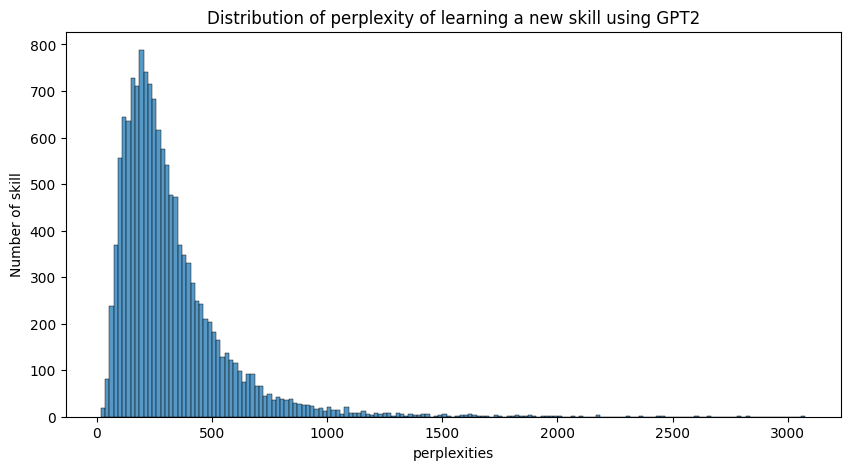

In [106]:
f, a = plt.subplots(figsize=(10, 5))
g = sns.histplot(data=F, x="perplexities")
g.set_title("Distribution of perplexity of learning a new skill using GPT2")
g.set_ylabel("Number of skill")

<ins>*Top most surpising skills to learn*</ins>

In [107]:
F.sort_values("perplexities", ascending=False).head(20)

,perplexities,input,skill
9092,3076.675293,i want to learn tally lumber,tally lumber
8523,2828.460449,i want to learn to procurement legislation,procurement legislation
11204,2790.992676,i want to learn plan beamhouse operations,plan beamhouse operations
4332,2661.844238,i want to learn to training subject expertise,training subject expertise
5831,2600.905762,i want to learn assess museum object condition,assess museum object condition
13154,2457.632812,i want to learn THC Hydra,THC Hydra
12811,2453.138184,i want to learn review completed contracts,review completed contracts
9506,2436.540771,i want to learn vacuum street debris,vacuum street debris
5001,2354.689209,i want to learn plan daily ship operations,plan daily ship operations
6250,2312.488281,i want to learn analyse drill engineering,analyse drill engineering


<ins>*Top least suprising skills to learn*</ins>

In [66]:
F.sort_values("perplexities", ascending=True).head(20)

,perplexities,input,skill
4560,18.870920,i want to learn to stay up-to-date with curren...,stay up-to-date with current events
580,22.966549,i want to learn to perform multiple tasks at t...,perform multiple tasks at the same time
5697,23.453165,i want to learn to stay up to date with social...,stay up to date with social media
13542,24.968121,i want to learn to stay up-to-date with music ...,stay up-to-date with music and video releases
5020,27.992762,i want to learn to use object-oriented program...,use object-oriented programming
6140,28.793699,i want to learn to obstetrics and gynaecology,obstetrics and gynaecology
2546,29.023550,i want to learn to play the piano,play the piano
2996,29.550997,i want to learn to stay up-to-date with latest...,stay up-to-date with latest book releases
9211,30.587366,i want to learn to make made-to-measure garments,make made-to-measure garments
1951,32.596348,i want to learn to pose in front of a camera,pose in front of a camera


In [54]:
## take the 15% of most surprising skill you would want to learn

most_surprise = F.sort_values("perplexities", ascending=False).head(int(len(F.index) * 0.15))

In [56]:
most_surprise.to_csv("generation/surprising_skills.csv") 

In [73]:
display(F[F.skill == "IBM Informix"])
display(F[F.skill == "Oracle Relational Database"])
display(F[F.skill == "SPARQL"])
display(F[F.skill == "SQL"])

,perplexities,input,skill
7250,447.313446,i want to learn IBM Informix,IBM Informix


,perplexities,input,skill
12057,321.027985,i want to learn Oracle Relational Database,Oracle Relational Database


,perplexities,input,skill
5141,98.159584,i want to learn to SPARQL,SPARQL


,perplexities,input,skill
4901,185.014954,i want to learn SQL,SQL


In [109]:
import json

with open("generation/frequency_vals.json", "w") as f:
    json.dump(F[["skill", "perplexities"]].set_index("skill").to_dict()["perplexities"], f)

For compose inputs :

In [32]:
perplexity = evaluate.load("perplexity", module_type="metric")
results = perplexity.compute(model_id="gpt2", predictions=ppl_inputs_compose)

Using pad_token, but it is not set yet.


  0%|          | 0/869 [00:00<?, ?it/s]

In [37]:
import json
with open("ppl_inputs_compose.json", "w") as f:
    json.dump(results, f)


results.update({'input': ppl_inputs_compose, "skill": list(emb_tax.name.values)})

In [39]:
F = pd.DataFrame(results).drop("mean_perplexity", axis=1)
display(F.sample(5))
display(F.describe())

,perplexities,input,skill
3061,159.184448,"i want to learn to e-procurement, which consis...",e-procurement
12927,82.865211,i want to learn to sell amusement park tickets...,sell amusement park tickets
3611,105.325333,i want to learn to assess the compatibility of...,assess the compatibility of individuals and an...
2953,72.455757,i want to learn to design musical events invol...,design musical events involving patients
12317,41.935215,"i want to learn to offer financial services, w...",offer financial services


,perplexities
count,13896.000000
mean,86.601380
std,46.642748
min,10.486667
25%,55.444448
50%,75.196075
75%,104.806316
max,486.176178


In [43]:
display("Low perplexity :")

display(F.sort_values("perplexities").head(5))

display("High perplexity :")

F.sort_values("perplexities").tail(5)


'Low perplexity :'

,perplexities,input,skill
2072,10.486667,i want to learn to diagnose rheumatic diseases...,diagnose rheumatic diseases
775,14.582417,"i want to learn to musculoskeletal anatomy, wh...",musculoskeletal anatomy
7867,14.840158,i want to learn to manage plans for the utilis...,manage plans for the utilisation of organic by...
12498,15.080435,i want to learn to maintain up-to-date aeronau...,maintain up-to-date aeronautical information m...
3716,15.394723,i want to learn to diving operation requiremen...,diving operation requirements


'High perplexity :'

,perplexities,input,skill
13706,442.045166,"i want to learn numerical sequences, which con...",numerical sequences
11406,446.836975,"i want to learn to deliver fertiliser, which c...",deliver fertiliser
11688,475.734406,"i want to learn to select loan objects, which ...",select loan objects
5942,479.646088,"i want to learn to grade young fish, which con...",grade young fish
12585,486.176178,"i want to learn to tend fans for machines, whi...",tend fans for machines


In [44]:
display(F[F.skill == "IBM Informix"])
display(F[F.skill == "Oracle Relational Database"])
display(F[F.skill == "SPARQL"])
display(F[F.skill == "SQL"])

,perplexities,input,skill
7250,47.40456,"i want to learn IBM Informix, which consist of...",IBM Informix


,perplexities,input,skill
12057,63.315639,"i want to learn Oracle Relational Database, wh...",Oracle Relational Database


,perplexities,input,skill
5141,39.946575,"i want to learn to SPARQL, which consist of : ...",SPARQL


,perplexities,input,skill
4901,29.520985,"i want to learn SQL, which consist of : The co...",SQL


/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


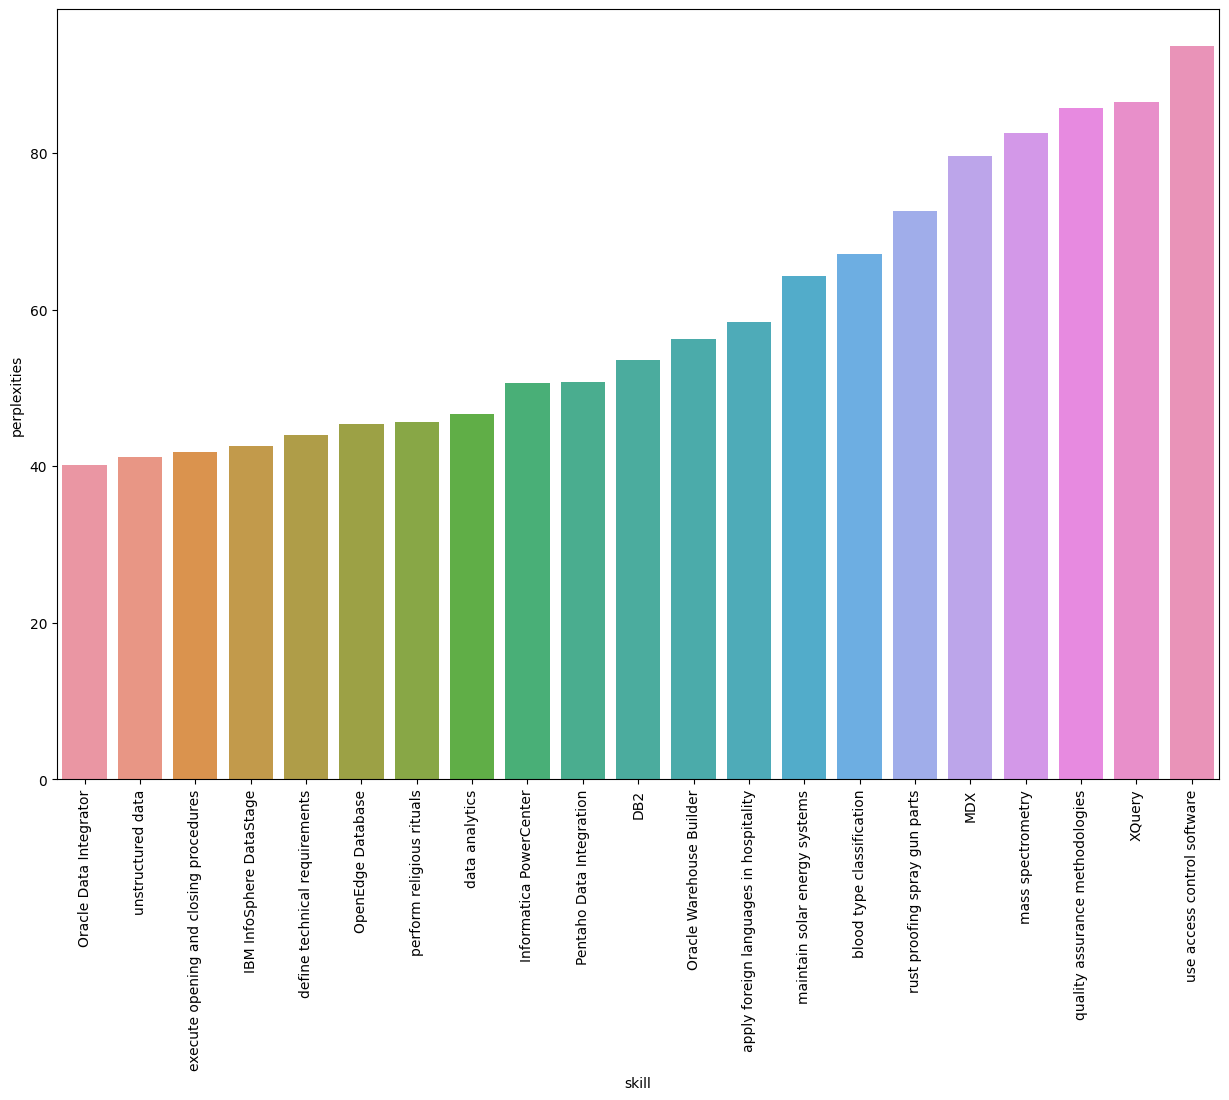

In [71]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
SQL_vec = emb_tax[emb_tax.name == "SQL"]["embeddings"].values[0].numpy()
all_embeddings = torch.cat(list(emb_tax[emb_tax.name != "SQL"]["embeddings"].values)).numpy()
k = 20
kNN_idxs = cosine_similarity(SQL_vec, all_embeddings).argsort()[0][-(k+1):]

knn_names = list(emb_tax.iloc[kNN_idxs]["name"].values)

F_knn = F[F.skill.isin(knn_names)]

f, a = plt.subplots(figsize=(15, 10))
g = sns.barplot(data=F_knn.sort_values("perplexities", ascending=True), x="skill", y="perplexities")
g.set_xticklabels(knn_names, rotation=90);

### Further result analysis

In [23]:
with open("generation/frequency_vals.json", "r") as f:
    F = json.load(f)

F = pd.DataFrame({'skill': list(F.keys()), 'popularity': list(F.values())})

In [26]:
F.sort_values("popularity")

,skill,popularity
4560,stay up-to-date with current events,18.870920
580,perform multiple tasks at the same time,22.966549
5697,stay up to date with social media,23.453165
13542,stay up-to-date with music and video releases,24.968121
5020,use object-oriented programming,27.992762
...,...,...
5831,assess museum object condition,2600.905762
4332,training subject expertise,2661.844238
11204,plan beamhouse operations,2790.992676
8523,procurement legislation,2828.460449


### Try to validate with the Google Trend 

In [8]:
from pytrends.request import TrendReq
import json
import pandas as pd
from tqdm.notebook import tqdm
import time


with open("generation/frequency_vals.json", "r") as f:
    F = json.load(f)

trends = TrendReq(hl="en-US", tz=360)

In [ ]:
all_skills = list(F.keys())
all_trends = []
consecutive_fail = 0
for i in tqdm(range(0, len(all_skills))):
    if(consecutive_fail > 10):
        break
    try :
        trends.build_payload([all_skills[i]], cat=0, timeframe='today 5-y')
        skill_trends = trends.interest_over_time().reset_index()
        all_trends.append(skill_trends)
        consecutive_fail = 0

    except :
        print("> skill not found : ", all_skills[i])
        consecutive_fail += 1
        time.sleep(10)

In [ ]:
from pytrends.request import TrendReq

trends = TrendReq(hl="en-US", tz=360)

tested_skills = ["SQL", "SPARQL", "XQuery", "LINQ"  , "N1QL", "MDX", "LDAP", "IBM Informix", "query languages", "Oracle Relational Database", "Oracle Warehouse Database", "Oracle Warehouse Builder", "DB2", "Pentaho Data Integration", "Informatica PowerCenter", "QlikView Expressor"]
all_trends = []
for i in tqdm(range(0, len(tested_skills))):
    try :
        trends.build_payload([tested_skills[i]], cat=0, timeframe='today 5-y')
        skill_trends = trends.interest_over_time().reset_index()
        all_trends.append(skill_trends)
        consecutive_fail = 0
        time.sleep(15)
    except Exception as e:
        print(e)
        print("> skill not found : ", tested_skills[i])
        print("sleeping...")
        time.sleep(15)

found_trends = [trend for trend in all_trends if len(trend.index) > 0]
colnames = [trend.columns[1] for trend in all_trends if len(trend.index) > 0]
dates = found_trends[0]["date"].apply(lambda x : str(x.month) + "/"  + str(x.year))

trendvalid = pd.concat([trend.reset_index(drop=True).drop("isPartial", axis=1).drop("date", axis=1) for trend in found_trends], axis=1, ignore_index=True)
trendvalid.columns = colnames
trendvalid["date"] = dates
trendvalid = trendvalid.groupby("date").mean() ## get mean per month


mavg_trendvalid = pd.DataFrame(trendvalid.mean(axis=0)).reset_index()
mavg_trendvalid.columns = ["skill", "valid_trend"]
mavg_trendvalid

## Popularity through PPL with better prompts

In [17]:
from lemminflect import getInflection

skill1 = "stay up-to-date with the news"
doc = nlp(skill1)
print("tag : ", doc[0].tag_)
print(getInflection(skill1.split(" ")[0], "VBG")[0] + skill1[1:])

skill2 = "staying up-to-date with the news"
doc = nlp(skill2)
print("tag : ", doc[0].tag_)
getInflection(skill2.split(" ")[0], "VBG")

tag :  VB
stayingtay up-to-date with the news
tag :  VBG


('stayinging',)

In [27]:
import spacy


nlp = spacy.load("en_core_web_sm")

def get_pp_input_1(skill):
    ## "For my job, I want to learn [to] {skill}"    
    doc = nlp(skill) 
    starts_with_noun = doc[0].tag_ == 'NNP'
    return f"For my job, I want to learn {'' if starts_with_noun else 'to '}{skill}."
    
def get_pp_input_2(skill):
    ## "I want a job that involved [skill[0].ing] {skill[1:]}"
    doc = nlp(skill)
    start_with_infinitif_word = doc[0].tag_ == 'VB' ## infintive verb
    base = "I want a job that involves "
    if(not start_with_infinitif_word):
        base += skill
    else :
        simple_tokens = skill.split(" ")
        verb = simple_tokens[0]
        verb_ing = getInflection(verb, "VBG")
        base += verb_ing[0] + " " + (" ".join(simple_tokens[1:]) if len(simple_tokens) > 0 else "")
    return base + "."

def get_pp_input_3(skill):
    ## "For my job, I want to learn [to] {skill}"    
    doc = nlp(skill) 
    starts_with_noun = doc[0].tag_ == 'NNP'
    return f"At my job, my main is skill is {'' if starts_with_noun else 'to '}{skill}."


transform = [get_pp_input_1,
             get_pp_input_2,
             get_pp_input_3,
             ]


ppl_inputs_simple = pd.DataFrame(emb_tax["name"])
tf_cols = []
for i, f in enumerate(transform):
    tf_cols.append(f"tf_{i}")
    ppl_inputs_simple[tf_cols[-1]] = ppl_inputs_simple["name"].progress_apply(f)
    print("> computed transform ", i)

  0%|          | 0/13896 [00:00<?, ?it/s]

> computed transform  0


  0%|          | 0/13896 [00:00<?, ?it/s]

> computed transform  1


  0%|          | 0/13896 [00:00<?, ?it/s]

> computed transform  2


In [29]:
perplexity = evaluate.load("perplexity", module_type="metric")
res = []
for tf_col in tf_cols:
    results = perplexity.compute(model_id="gpt2", predictions=list(ppl_inputs_simple[tf_col].values))
    res.append(results)

Using pad_token, but it is not set yet.


  0%|          | 0/869 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/869 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/869 [00:00<?, ?it/s]

['tf_0', 'tf_1', 'tf_2']

In [79]:
for i, tf_col in enumerate(tf_cols):
    ppl_inputs_simple[tf_col + "_ppl"] = res[i]["perplexities"]
    ppl_inputs_simple[tf_col + "_ppl_std"] = (ppl_inputs_simple[tf_col + "_ppl"] - ppl_inputs_simple[tf_col + "_ppl"].mean()) / ppl_inputs_simple[tf_col + "_ppl"].std()
    ppl_inputs_simple[tf_col + "_ppl_mm"] = (ppl_inputs_simple[tf_col + "_ppl"] - ppl_inputs_simple[tf_col + "_ppl"].min()) / (ppl_inputs_simple[tf_col + "_ppl"].max() - ppl_inputs_simple[tf_col + "_ppl"].min())

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/

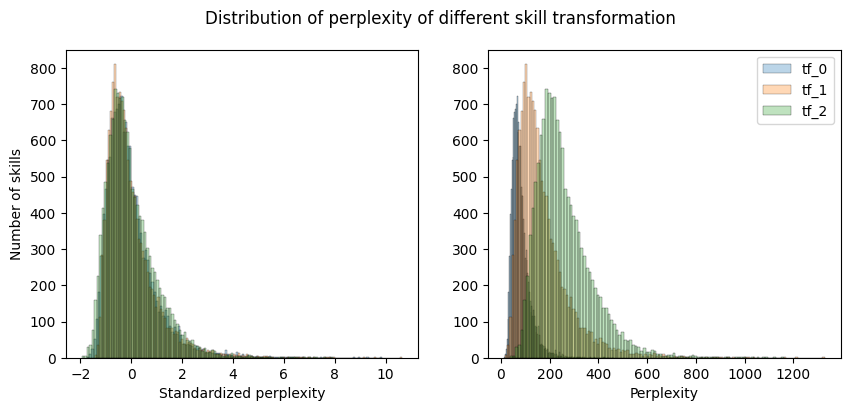

In [40]:
f, a = plt.subplots(1, 2, figsize=(10, 4))
for tf_col in tf_cols:
    sns.histplot(data=ppl_inputs_simple, x=tf_col + "_ppl_std", label=tf_col, alpha=0.3, ax=a[0])
    sns.histplot(data=ppl_inputs_simple, x=tf_col + "_ppl", label=tf_col, alpha=0.3, ax=a[1])

a[0].set_ylabel("Number of skills")
a[1].set_ylabel("")

a[0].set_xlabel("Standardized perplexity")
a[1].set_xlabel("Perplexity")
f.suptitle("Distribution of perplexity of different skill transformation")
plt.legend()

In [80]:
ppl_inputs_simple["mean_std_ppl"] = ppl_inputs_simple[[x + "_ppl_std" for x in tf_cols]].mean(axis=1)
ppl_inputs_simple["mean_mm_ppl"] = ppl_inputs_simple[[x + "_ppl_mm" for x in tf_cols]].mean(axis=1)


In [50]:
ppl_inputs_simple[["name", "mean_std_ppl"]].sort_values('mean_std_ppl', ascending=True).head(5)

,name,mean_std_ppl
4560,stay up-to-date with current events,-1.698764
580,perform multiple tasks at the same time,-1.688207
5697,stay up to date with social media,-1.626477
13542,stay up-to-date with music and video releases,-1.612220
10877,"maintain a safe, hygienic and secure working e...",-1.597543


### Reducing to tech inputs

In [53]:
tech_skills = pd.read_csv("../../../esco/digitalSkillsCollection_en.csv")
tech_skills_names = set(tech_skills.preferredLabel.values).union(set(tech_skills.altLabels.values))
print("Complete number of skills : ", len(emb_tax.index))
print("Number of tech skills : ", len(emb_tax[emb_tax.name.isin(tech_skills_names)].index))

tech_popularity = ppl_inputs_simple[ppl_inputs_simple.name.isin(tech_skills_names)][["name", "mean_std_ppl"]]

Complete number of skills :  13896
Number of tech skills :  1201


In [55]:
display("Low perplexities : most popular")
display(tech_popularity.sort_values("mean_std_ppl", ascending=True).head(15))
display("High perplexities : least popular")
display(tech_popularity.sort_values("mean_std_ppl", ascending=False).head(15))

'Low perplexities : most popular'

,name,mean_std_ppl
5697,stay up to date with social media,-1.626477
5020,use object-oriented programming,-1.510689
10134,implement anti-virus software,-1.382091
2633,use meteorological tools to forecast meteorolo...,-1.381706
10403,design microelectromechanical systems,-1.380187
12498,maintain up-to-date aeronautical information m...,-1.378106
6911,keep up-to-date to computer trends,-1.377740
3580,collect real-time geolocation information,-1.363905
11379,protect health and well-being while using digi...,-1.356210
5873,create 3D characters,-1.340267


'High perplexities : least popular'

,name,mean_std_ppl
13154,THC Hydra,5.595122
678,assess integrated domotics systems,4.884493
2664,OpenEdge Advanced Business Language,4.419590
7950,airspace system block upgrades,4.022199
11715,domotic systems,4.013904
7860,operate train integrated electronic control ce...,3.690720
419,WizIQ,3.592645
9260,analyse stress resistance of materials,3.485399
7451,analyse clothing 3d prototypes,3.348626
10125,Samurai Web Testing Framework,3.317987


In [58]:
ppl_inputs_simple.to_csv("ppl_3_sentences_all_skills.csv")

(array([2686., 3566., 3100., 2211., 1282.,  698.,  253.,   73.,   22.,
           5.]),
 array([1.68975218e-08, 2.94081168e-05, 5.87993361e-05, 8.81905553e-05,
        1.17581775e-04, 1.46972994e-04, 1.76364213e-04, 2.05755432e-04,
        2.35146652e-04, 2.64537871e-04, 2.93929090e-04]),
 <BarContainer object of 10 artists>)

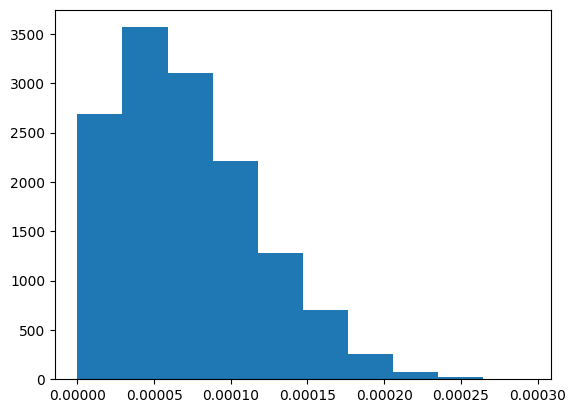

In [60]:
import numpy as np

dist = np.exp((-ppl_inputs_simple["mean_std_ppl"])) / np.exp((-ppl_inputs_simple["mean_std_ppl"])).sum()
plt.hist(dist)

/tmp/ipykernel_48894/3203952261.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distdf["F"] = softmax(-distdf["mean_std_ppl"])
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ve

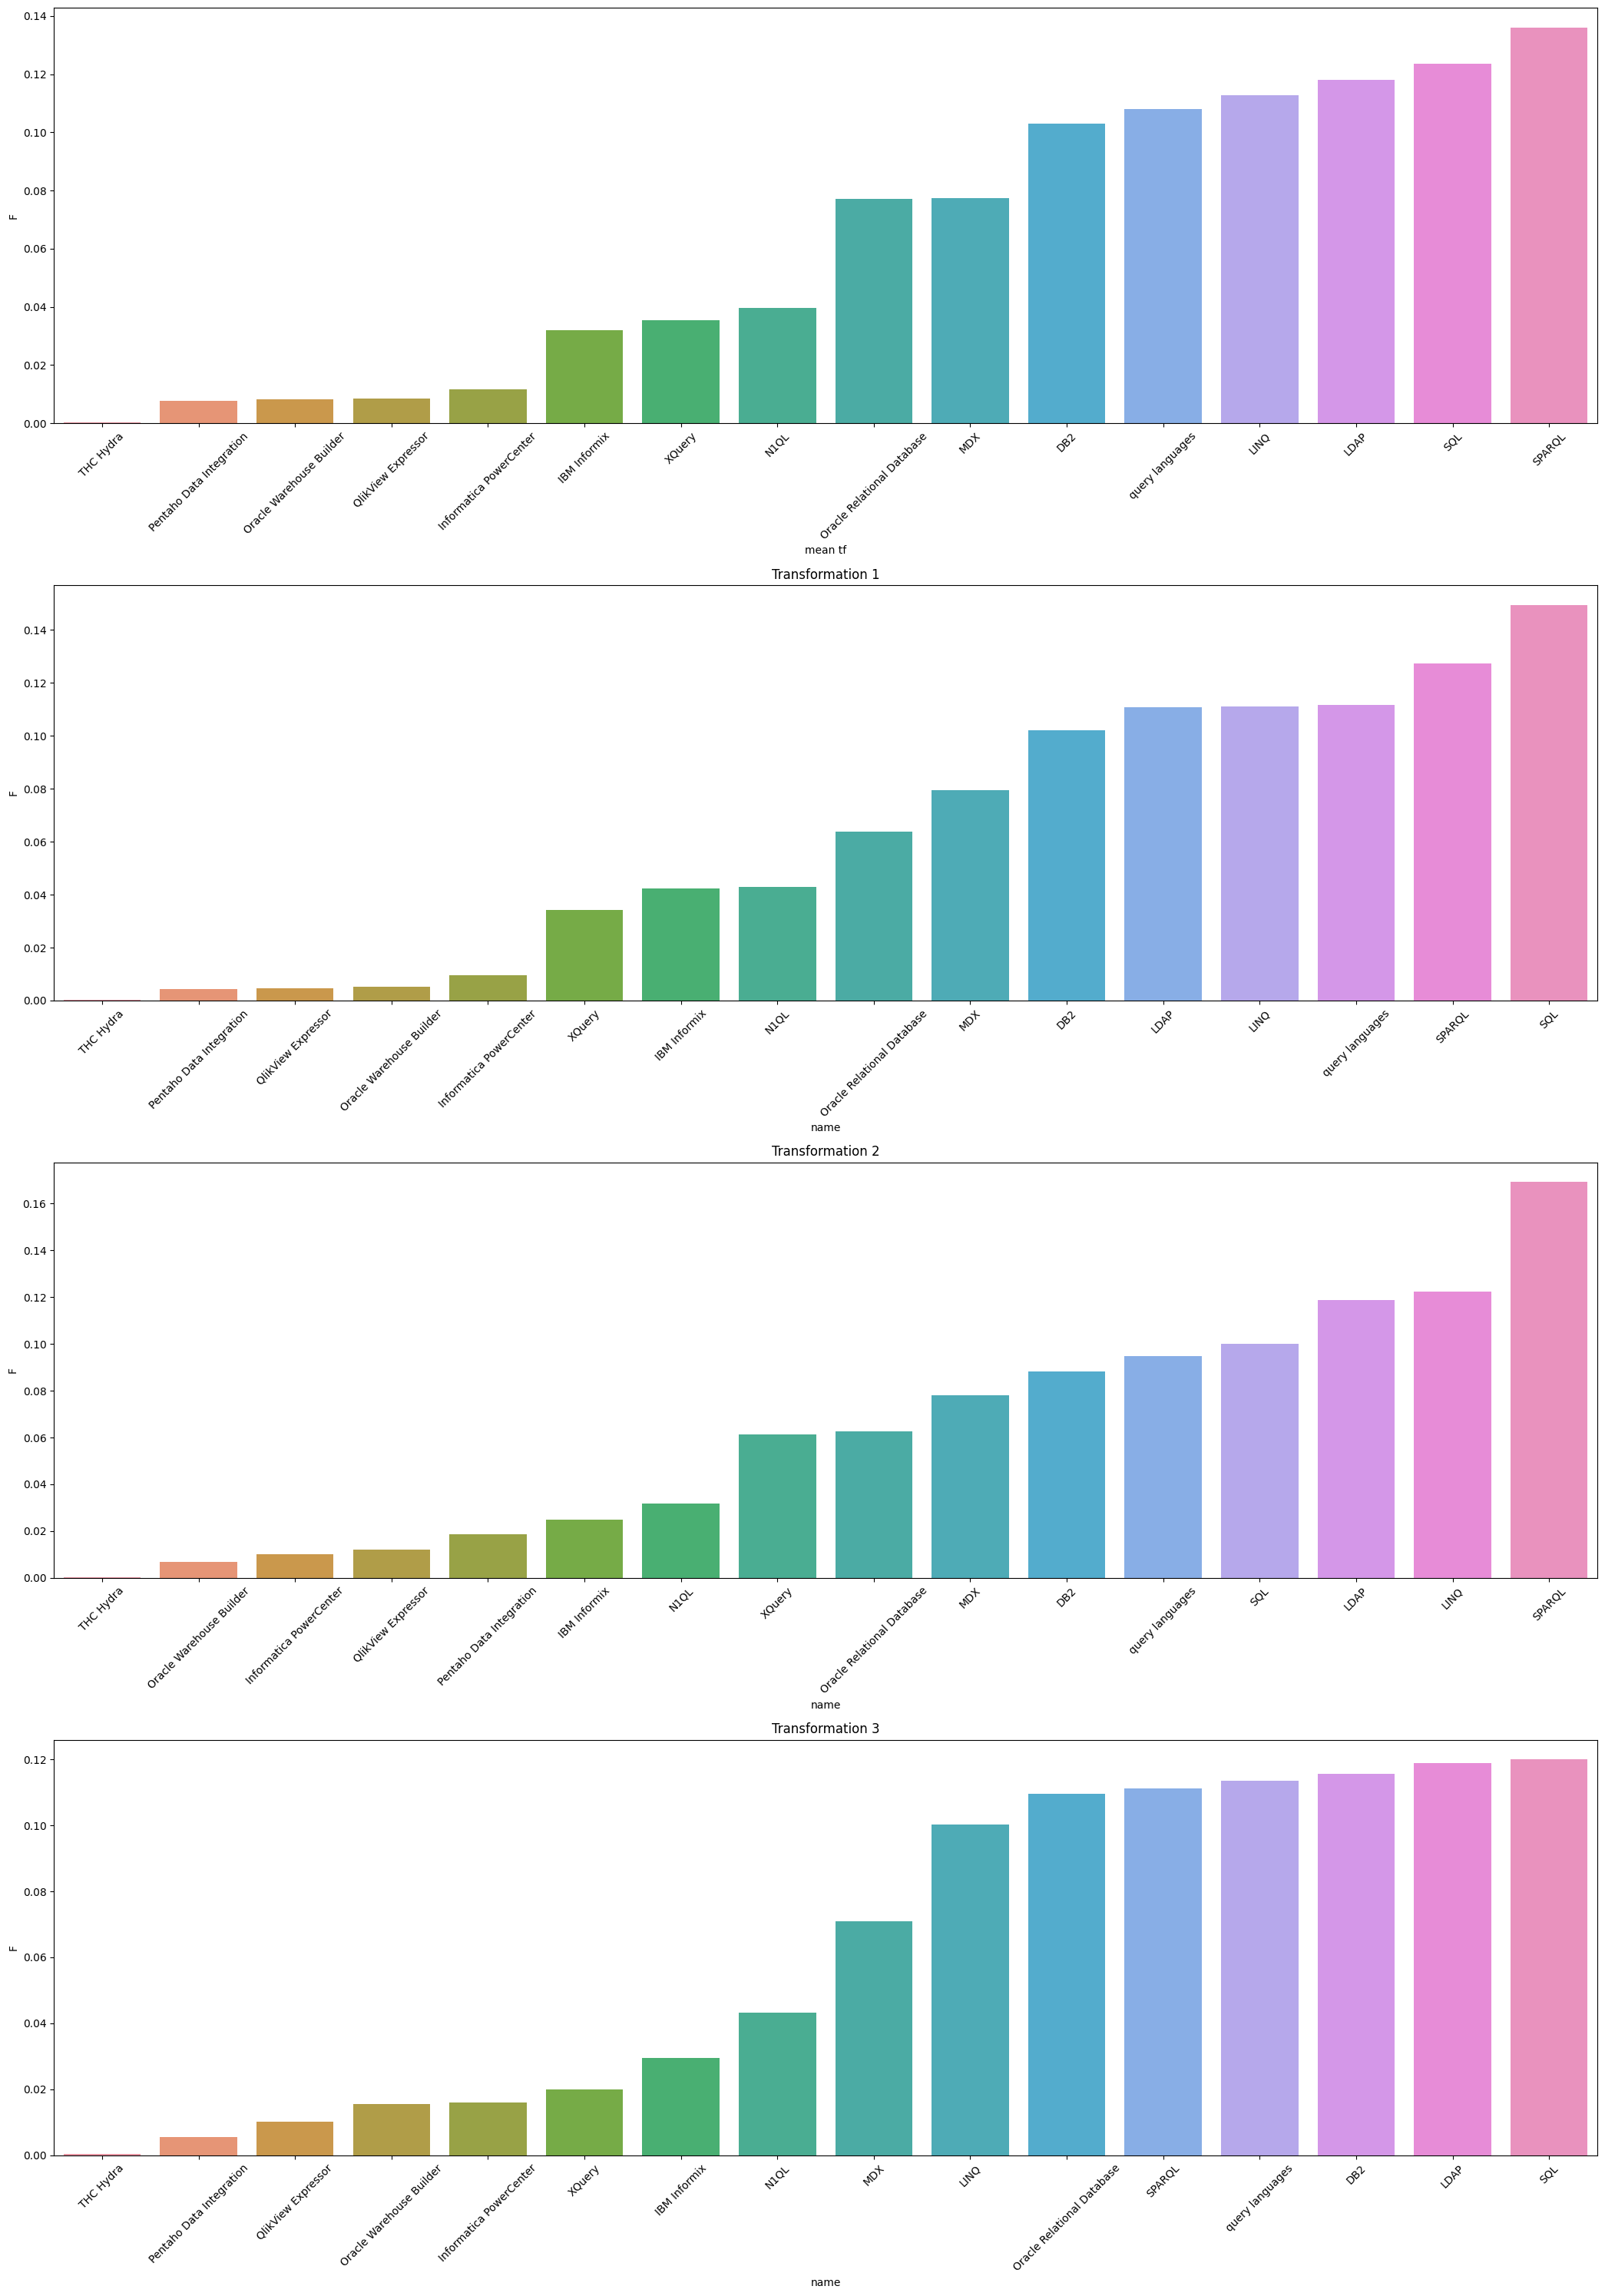

In [108]:
sub = ["PostreSQL", "THC Hydra", "SQL", "SPARQL", "XQuery", "LINQ"  , "N1QL", "MDX", "LDAP", "IBM Informix", "query languages", "Oracle Relational Database", "Oracle Warehouse Database", "Oracle Warehouse Builder", "DB2", "Pentaho Data Integration", "Informatica PowerCenter", "QlikView Expressor"]
distdf = ppl_inputs_simple[ppl_inputs_simple.name.isin(sub)]
softmax = lambda x : np.exp(x) / np.exp(x).sum()


f, a = plt.subplots(4, 1, figsize=(21, 30))
distdf["F"] = softmax(-distdf["mean_std_ppl"])
distdf = distdf.sort_values("F")
g = sns.barplot(data=distdf, y="F", x="name", ax=a[0])
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_xlabel("mean tf")
for i, col in enumerate(tf_cols):
    distdf["F"] = softmax(-distdf[col + '_ppl_std'])
    distdf = distdf.sort_values("F")
    g = sns.barplot(data=distdf, y="F", x="name", ax=a[i + 1], label=tf_col)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(f"Transformation {i+1}")
plt.tight_layout()

